In [2]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from STOMPnet import STOMPnet

In [39]:
data_settings_str = '_3agentdebug' +\
                '_modelname_bitpop' +\
                '_corr_1' +\
                '_ensemble_sum' +\
                '_M_2' +\
                '_simulationdata' +\
                '_actsel_greedy' +\
                '_numepi_100' +\
                '_K_5' +\
                '_N_4' +\
                '_T_100'
print(data_settings_str)
seed_idx = 0
training_settings_str = '_STOMPnet' +\
                '_M_2' +\
                '_L_4' +\
                '_nfeatures_2' +\
                '_cap_250' +\
                '_trainseed_0' +\
                '_epochs_10' +\
                '_batchsz_16' +\
                '_lr_0.001'
print(training_settings_str)

_3agentdebug_modelname_bitpop_corr_1_ensemble_sum_M_2_simulationdata_actsel_greedy_numepi_100_K_5_N_4_T_100
_STOMPnet_M_2_L_4_nfeatures_2_cap_250_trainseed_0_epochs_10_batchsz_16_lr_0.001


In [40]:
out_dir = "output/"
data_settings = np.load(out_dir + data_settings_str + ".npy", allow_pickle=True).item()
data_root = out_dir + data_settings_str + f"_dataseed_{seed_idx}"

data = np.load(data_root+".npy", allow_pickle=True).item()
training_dict = np.load(data_root + training_settings_str + ".npy", allow_pickle=True).item()
model = np.load(data_root + training_settings_str+ '_state_dict.pt')
import json
print('data')
print(json.dumps(data_settings,sort_keys=True, indent=4))
print('\ntraining')
print(json.dumps(training_dict,sort_keys=True, indent=4))

data
{
    "actsel": "greedy",
    "dataset_label": "3agentdebug_modelname_bitpop_corr_1_ensemble_sum_M_2",
    "episode_length": 100,
    "num_episodes": 100,
    "num_seeds": 2,
    "sys_parameters": {
        "K": 5,
        "N": 4,
        "action_space_dim": 2,
        "jointagent_groundmodel_paras": {
            "M": 2,
            "corr": 1,
            "ensemble": "sum",
            "modelname": "bitpop"
        }
    }
}

training
{
    "data_path": "output/_3agentdebug_modelname_bitpop_corr_1_ensemble_sum_M_2_simulationdata_actsel_greedy_numepi_100_K_5_N_4_T_100_dataseed_0",
    "model_paras": {
        "L": 4,
        "M": 2,
        "hidden_capacity": 250,
        "model_name": "STOMPnet",
        "nfeatures": 2
    },
    "training_data": {
        "loss": [
            2.7042076847076415,
            2.6947701221466063,
            2.694466296005249,
            2.6948256664276125,
            2.6927669818878175,
            2.6934152362823487,
            2.693669591522

### Dataset analysis

In [41]:
states=np.array(data["states"]) #used only 1 seed
actions=np.array(data["actions"])
episode_times=np.array(data["times"])

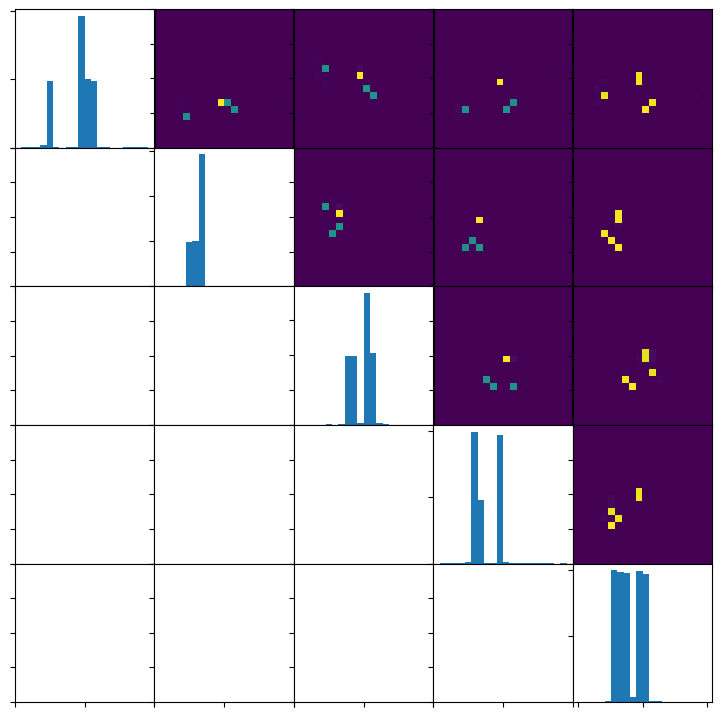

In [42]:
K=states.shape[1]
fig,ax=pl.subplots(K,K,figsize=(9,9))
for rit in range(K):
    for cit in range(K):
        if rit==cit:
            ax[rit,cit].hist(states[:,rit],bins=20)
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)

In [43]:
orthant_index_seq=np.array([np.sum(np.power(2,np.arange(K))[state>0.5]) for state in states])

In [44]:
np.array([np.power(2,np.arange(K))[state>0.5] for state in states]).shape

/tmp/ipykernel_796/2505405964.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([np.power(2,np.arange(K))[state>0.5] for state in states]).shape


(10000,)

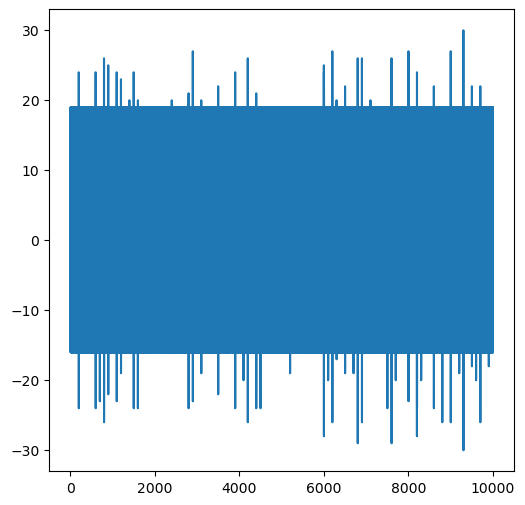

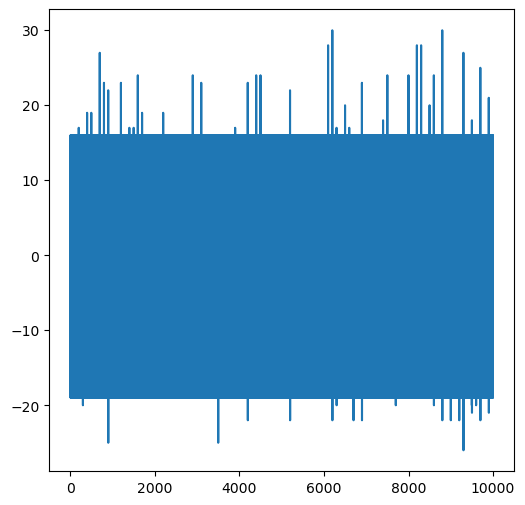

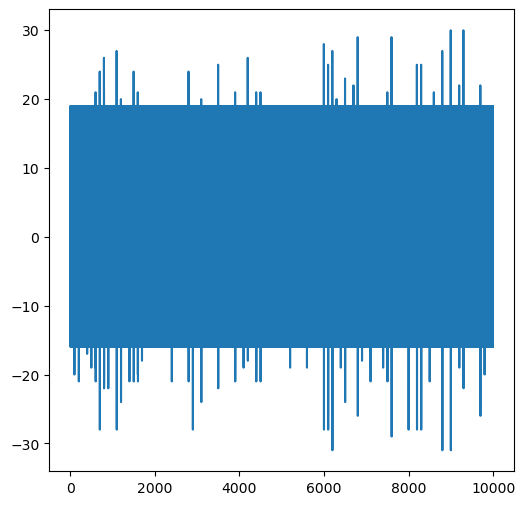

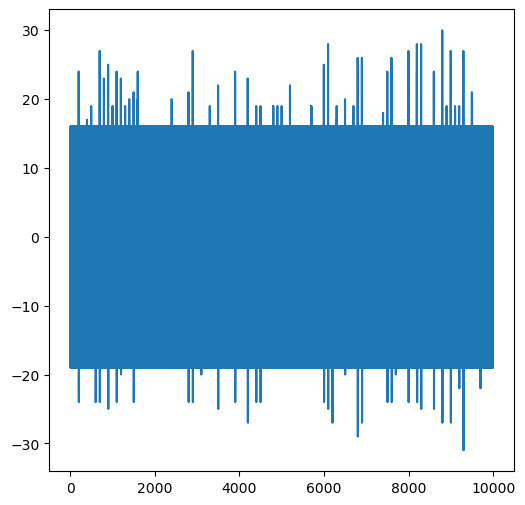

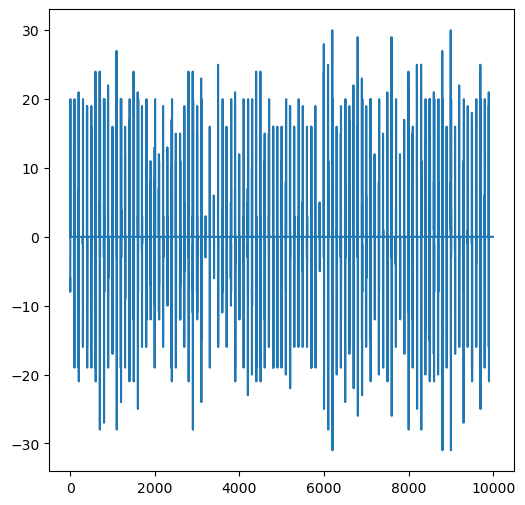

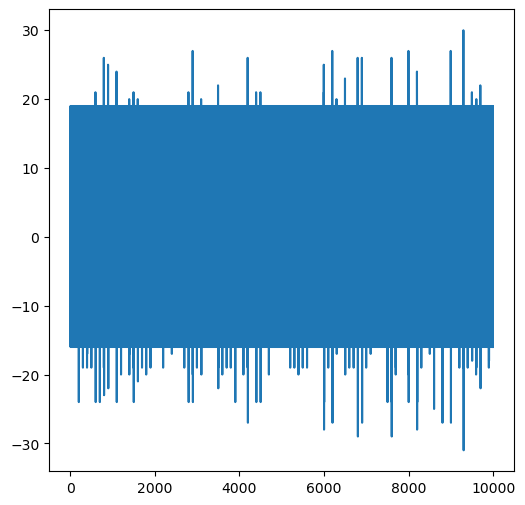

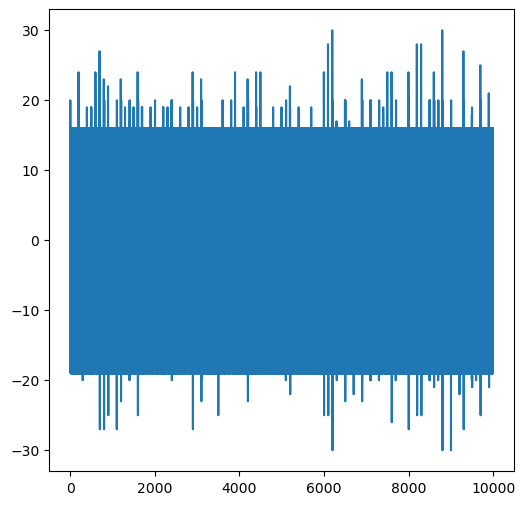

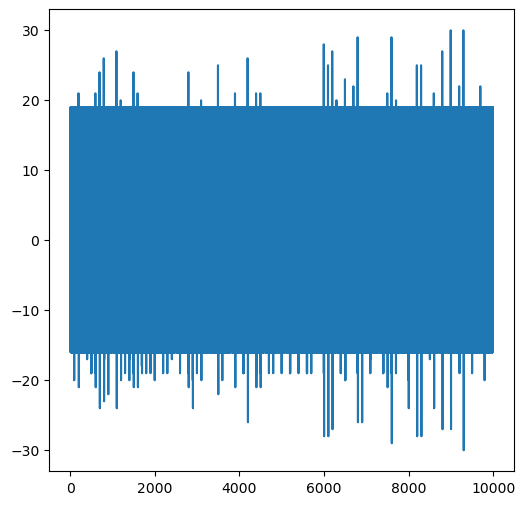

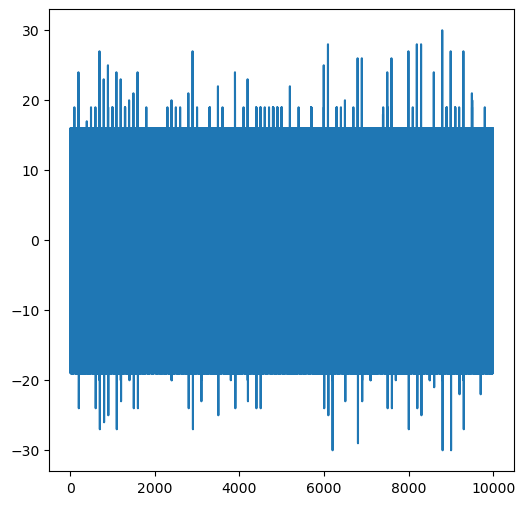

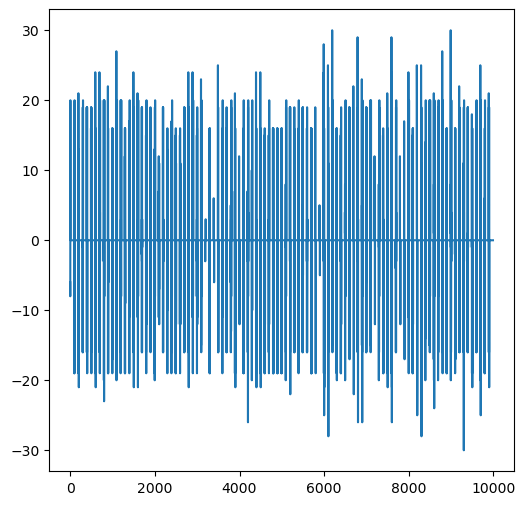

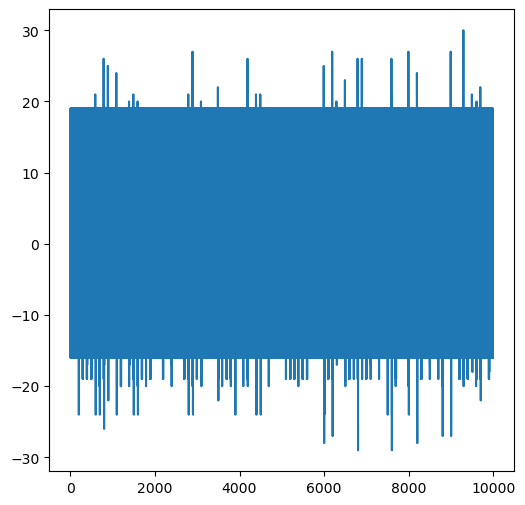

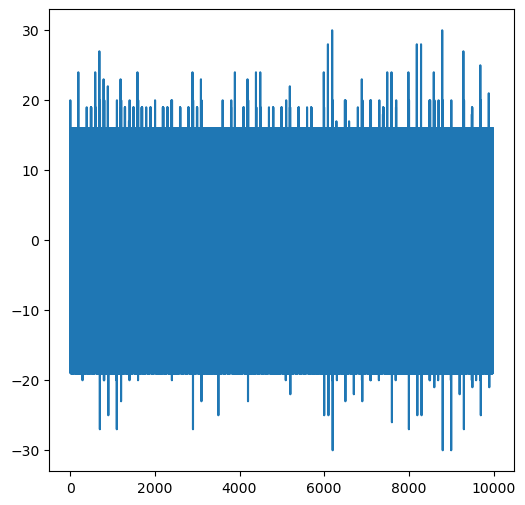

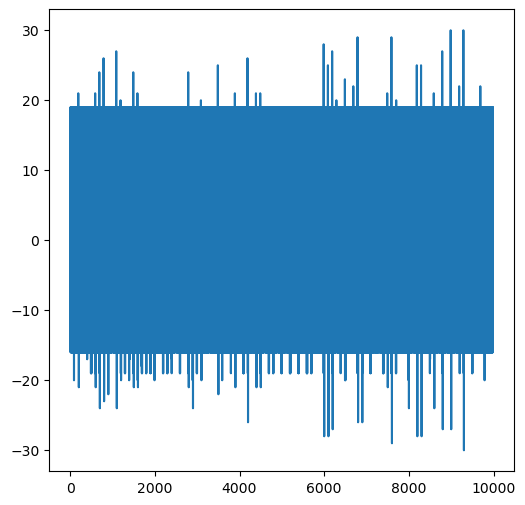

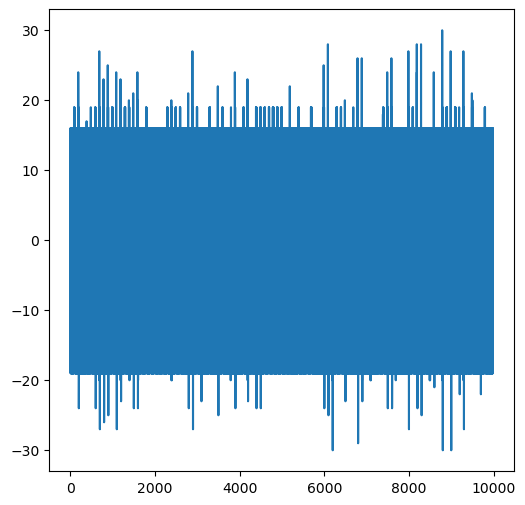

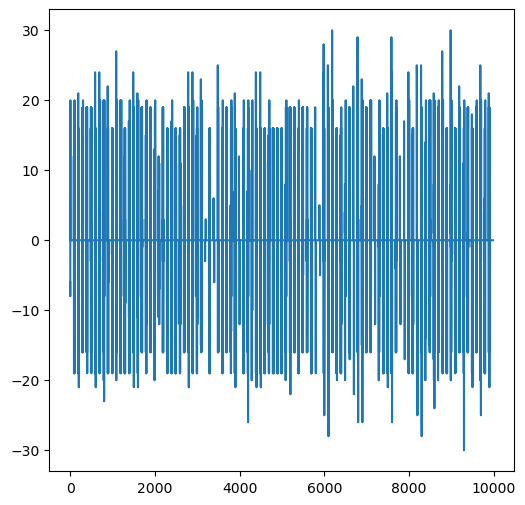

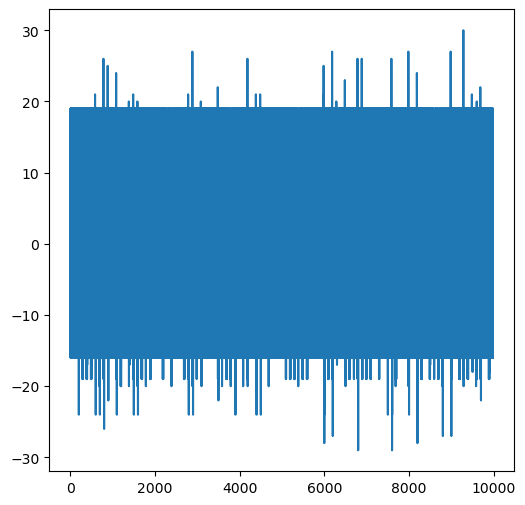

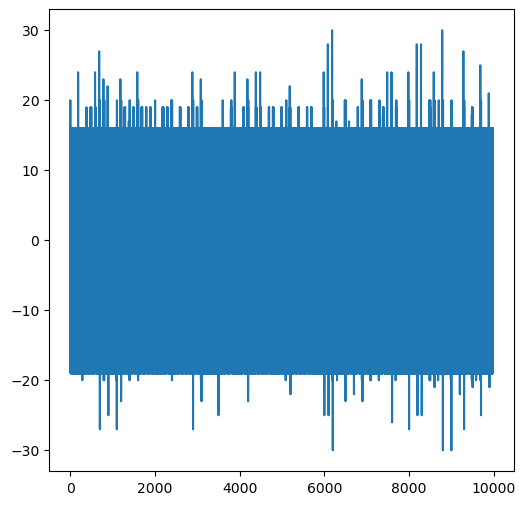

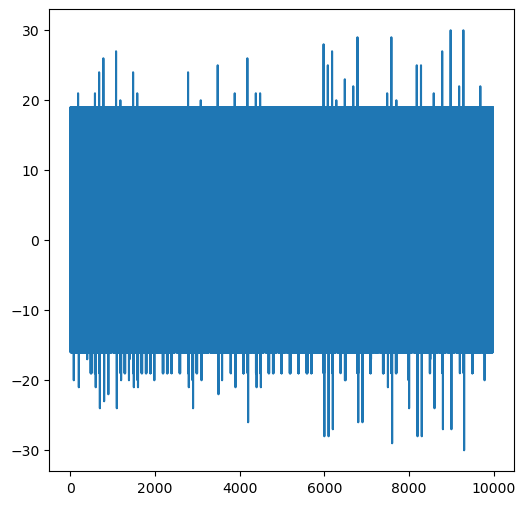

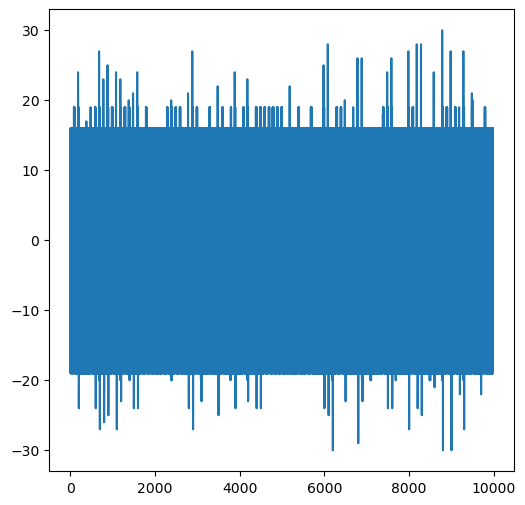

In [45]:
for shift in range(1,20):
    fig,ax=pl.subplots(figsize=(6,6))
    ax.plot(orthant_index_seq[shift:]-orthant_index_seq[:-shift])

/tmp/ipykernel_1320/4098084925.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);


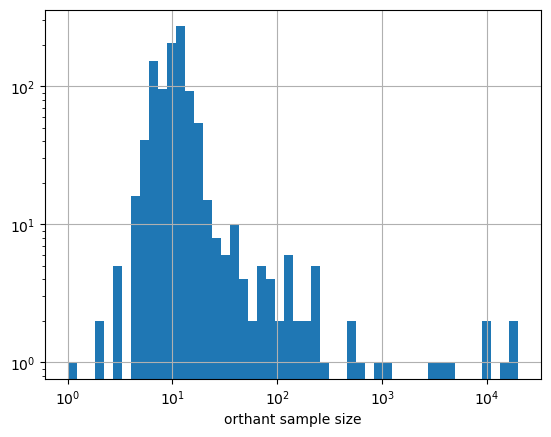

In [48]:
# plot binned states
df = pd.DataFrame(states, columns=range(states.shape[1]))
binned_df=(df>0.5)
outdf=binned_df.groupby(binned_df.columns.tolist(),as_index=False).size()#/len(df)
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant sample size')
ax.set_yscale('log')

In [46]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device", flush=True)

# Abstraction system
num_abs_agents = training_dict['model_paras']['M']
abs_action_space_dim =  training_dict['model_paras']['L']  # number of discrete abstract actions
# abstract action policy network parameters
hidden_capacity = training_dict['model_paras']['hidden_capacity']
enc_hidden_dim = int(hidden_capacity/num_abs_agents)
action_space_dim = 2
state_space_dim = data_settings['sys_parameters']['K']
num_agents = data_settings['sys_parameters']['N']
# Initialize abstraction system model
net = STOMPnet(
            state_space_dim,
            abs_action_space_dim,
            enc_hidden_dim,
            num_agents,
            num_abs_agents,
            action_space_dim=action_space_dim
        )
net.to(device)
state_dict=net.state_dict()
print(f"has {sum(p.numel() for p in state_dict.values())} parameters")

Using cpu device
has 264678 parameters


In [55]:
import itertools
from torch import nn
def get_probs_on_vertices_from_model(net):
    net.eval()
    with torch.no_grad():
        vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=10)))
        logit_arrays=net(vertex_states)
        print(logit_arrays.shape)
        f=nn.Softmax(dim=-1)
        return np.array(f(logit_arrays))
    
def get_probs_on_vertices_from_data(data):
    states=np.array(data["states"]) #used only 1 seed
    actions=np.array(data["actions"])
    vertex_states = torch.Tensor(list(itertools.product([0, 1], repeat=10)))
    states=states>0.5
    actions_on_vertices=-np.ones((vertex_states.shape[0],actions.shape[1]))
    got_list=[]
    for i,binarized_state in enumerate(states[:20000]): 
        for j,vertex_state in enumerate(vertex_states):
            if np.all(binarized_state == vertex_state):
                actions_on_vertices[j]=actions[i]
                break
        if np.mod(i,100)==0:
            print(np.sum(actions_on_vertices==-1))
    return actions_on_vertices

In [56]:
prelearning_probs=get_probs_on_vertices_from_model(net)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1024x10 and 5x125)

In [72]:
state_dict = torch.load(outdir + trainedmodel_filename)
net.load_state_dict(state_dict)
postlearning_probs=get_probs_on_vertices_from_model(net)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 2x125)

In [1]:
 data_actions=get_probs_on_vertices_from_data(data)

NameError: name 'get_probs_on_vertices_from_data' is not defined

In [8]:
prelearning_probs

array([[0.49313155, 0.5       , 0.4920286 , ..., 0.5       , 0.4966429 ,
        0.5       ],
       [0.49179345, 0.5       , 0.49294552, ..., 0.5       , 0.49719578,
        0.5       ],
       [0.48934925, 0.5       , 0.49242148, ..., 0.5       , 0.49492875,
        0.49990657],
       ...,
       [0.49375886, 0.5       , 0.4917415 , ..., 0.5       , 0.49781135,
        0.5       ],
       [0.49225354, 0.5       , 0.49283865, ..., 0.5       , 0.4976982 ,
        0.5       ],
       [0.4897338 , 0.5       , 0.49234125, ..., 0.5       , 0.49492875,
        0.5       ]], dtype=float32)

In [9]:
postlearning_probs

NameError: name 'postlearning_probs' is not defined

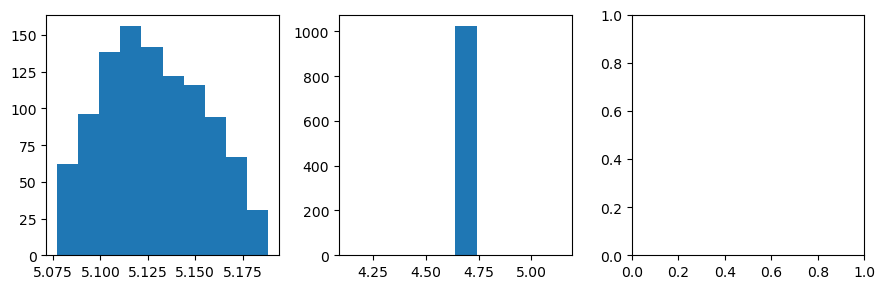

In [13]:
fig,ax=pl.subplots(1,3,figsize=(9,3))
ax[0].hist(np.sum(prelearning_probs,axis=1))
ax[1].hist(np.sum(postlearning_probs,axis=1))
fig.tight_layout()

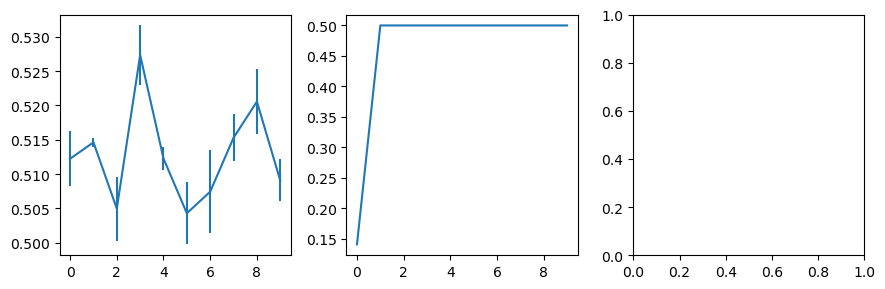

In [14]:
fig,ax=pl.subplots(1,3,figsize=(9,3))
ax[0].errorbar(x=range(len(prelearning_probs[0])),y=np.mean(prelearning_probs,axis=0),yerr=np.std(prelearning_probs,axis=0))
ax[1].errorbar(x=range(len(postlearning_probs[0])),y=np.mean(postlearning_probs,axis=0),yerr=np.std(postlearning_probs,axis=0))
fig.tight_layout()

In [38]:
data_actions=data_actions[data_actions[:,0]!=-1]

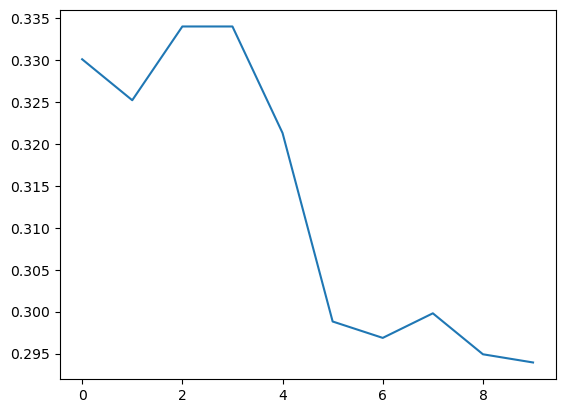

In [60]:
fig,ax=pl.subplots()
ax.plot(np.mean(data_actions,axis=0))

Text(0, 0.5, 'loss')

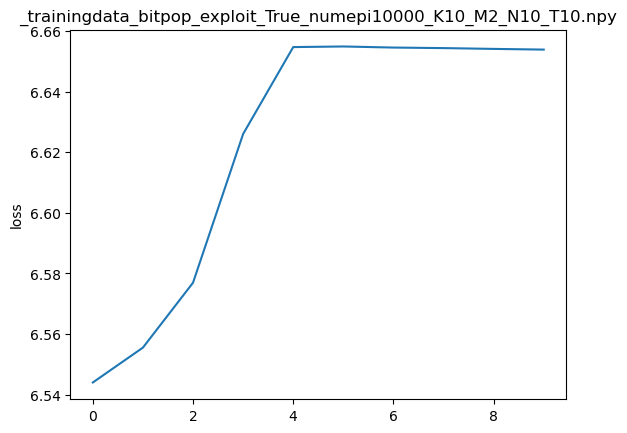

In [4]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

In [5]:
loss_data

array([6.54402432, 6.555533  , 6.57695433, 6.62602995, 6.65470538,
       6.65490488, 6.65454807, 6.65436967, 6.65410611, 6.65387374])

In [46]:
data = np.load(outdir + data_filename, allow_pickle=True).item()
batch_size =16
seed_idx = 0
states = data["states"][seed_idx]
actions = data["actions"][seed_idx]

dataset = CustomDataset(states, actions)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [47]:
actions

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 0]])

In [34]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

In [43]:
len(train_loader)*16

100000

In [39]:
for i, datat in enumerate(train_loader, 0):
    inputs, labels = datat
    print(f"in:{inputs.shape}, out:{labels.shape}")
    if i>100:
        break

in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])
in:torch.Size([16, 10]), out:torch.Size([16, 10])


Text(0, 0.5, 'loss')

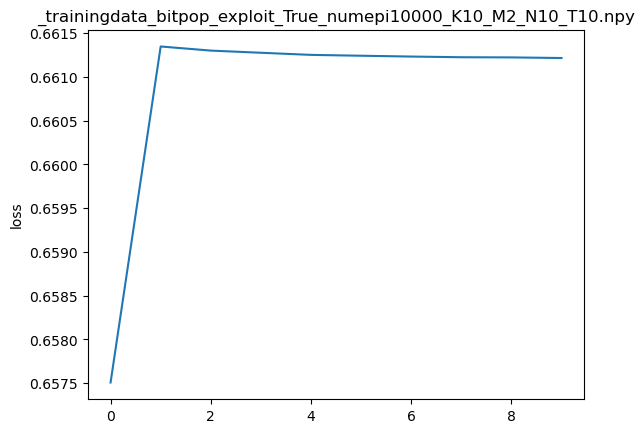

In [26]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

Analyze datasets

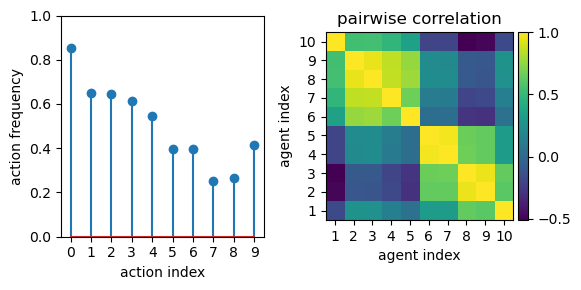

In [62]:
from utils import get_corr_matrix
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_xticks(range(num_agents))
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

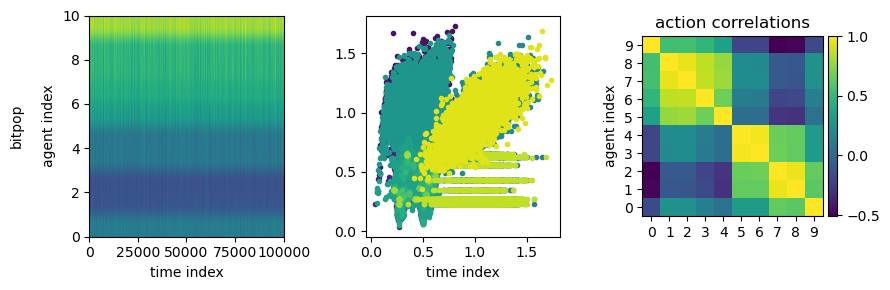

In [63]:
from utils import compare_plot
fig=compare_plot([outdir+data_filename])
fig.savefig(f'{data_filename[:-4]}_summary_fig.pdf', transparent=True, bbox_inches="tight", dpi=300)


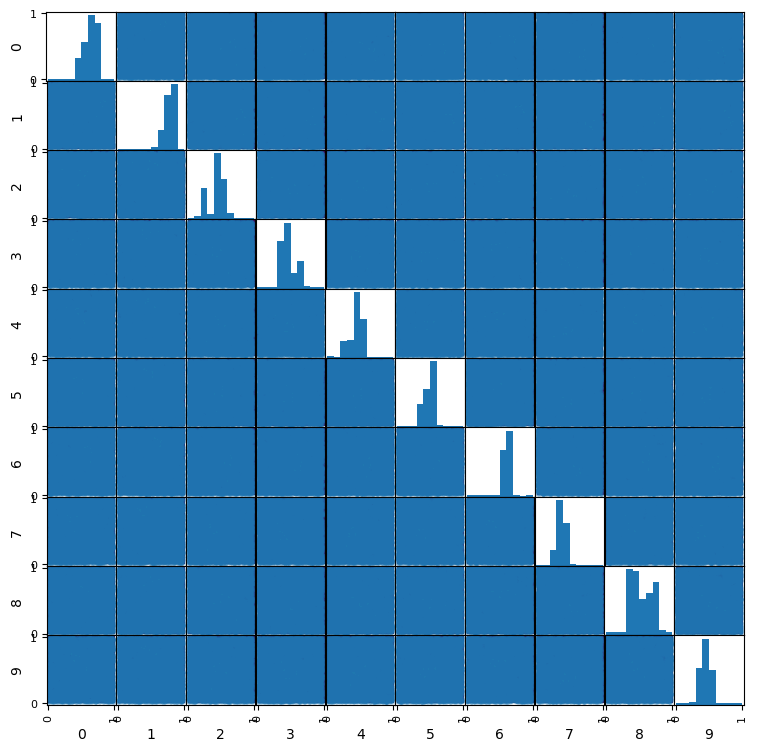

In [10]:
df = pd.DataFrame(states, columns=range(states.shape[1]))
axis_array=pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(9,9));
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit!=cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=50)
            extent = [0, 1, 0, 1]
#             axis.remove()
            axis.imshow(heatmap.T, extent=extent, origin='lower')

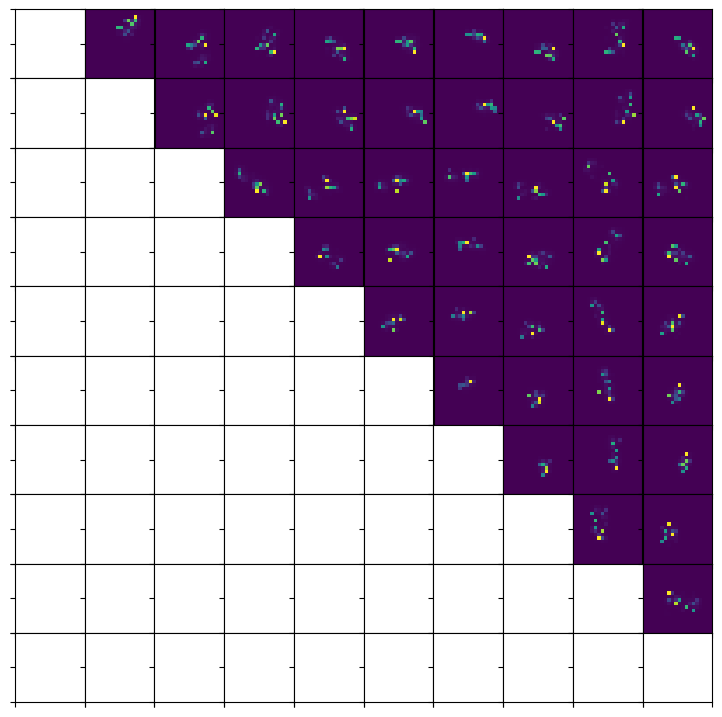

In [11]:
fig,ax=pl.subplots(*axis_array.shape,figsize=(9,9))
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
#             axis.remove()
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

/tmp/ipykernel_1694/3604754051.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);


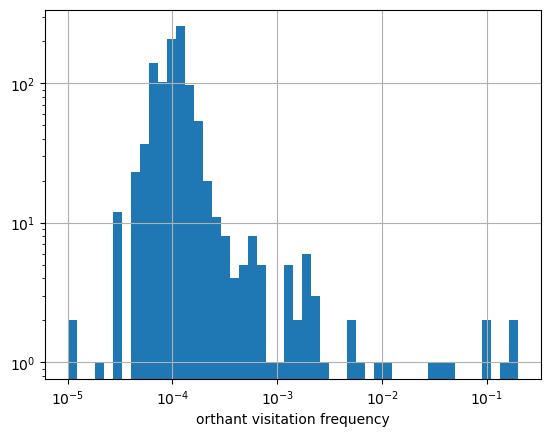

In [13]:
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant visitation frequency')
ax.set_yscale('log')